In [1]:
%pip install IPython

Note: you may need to restart the kernel to use updated packages.


In [2]:
import importlib
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
# Conditional skipping of https://kioku-space.com/en/jupyter-skip-execution/
@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

get_ipython().register_magic_function(skip_if, 'cell')

In [3]:
%%skip_if importlib.util.find_spec('Jinja2') is not None
%pip install Jinja2

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import json
import plotly.graph_objects as go
from pyproj import Transformer

# CS 365 Final Project: Transit Regina Data Wrangling

## Janice Cotcher

## December 5, 2025

**Data Source:** City of Regina Open Data Portal

**Dataset:** Transit Stops and Routes (November 20, 2025)

## Dataset Source & License

**Source:** [City of Regina Open Data Portal](https://open.regina.ca)

- Bus Stop Locations (yqrStops.json)
- Transit Routes (yqrRoutes.json)
- General Transit Feed Specification(routes.txt, stops.txt, trips.txt, stop_times.txt)

**License:** Open Government License - Regina

- Allows educational and commercial use
- No Personally Identifiable Information - only public infrastructure data

**Why this matters:** Understanding transit accessibility and route coverage for urban planning

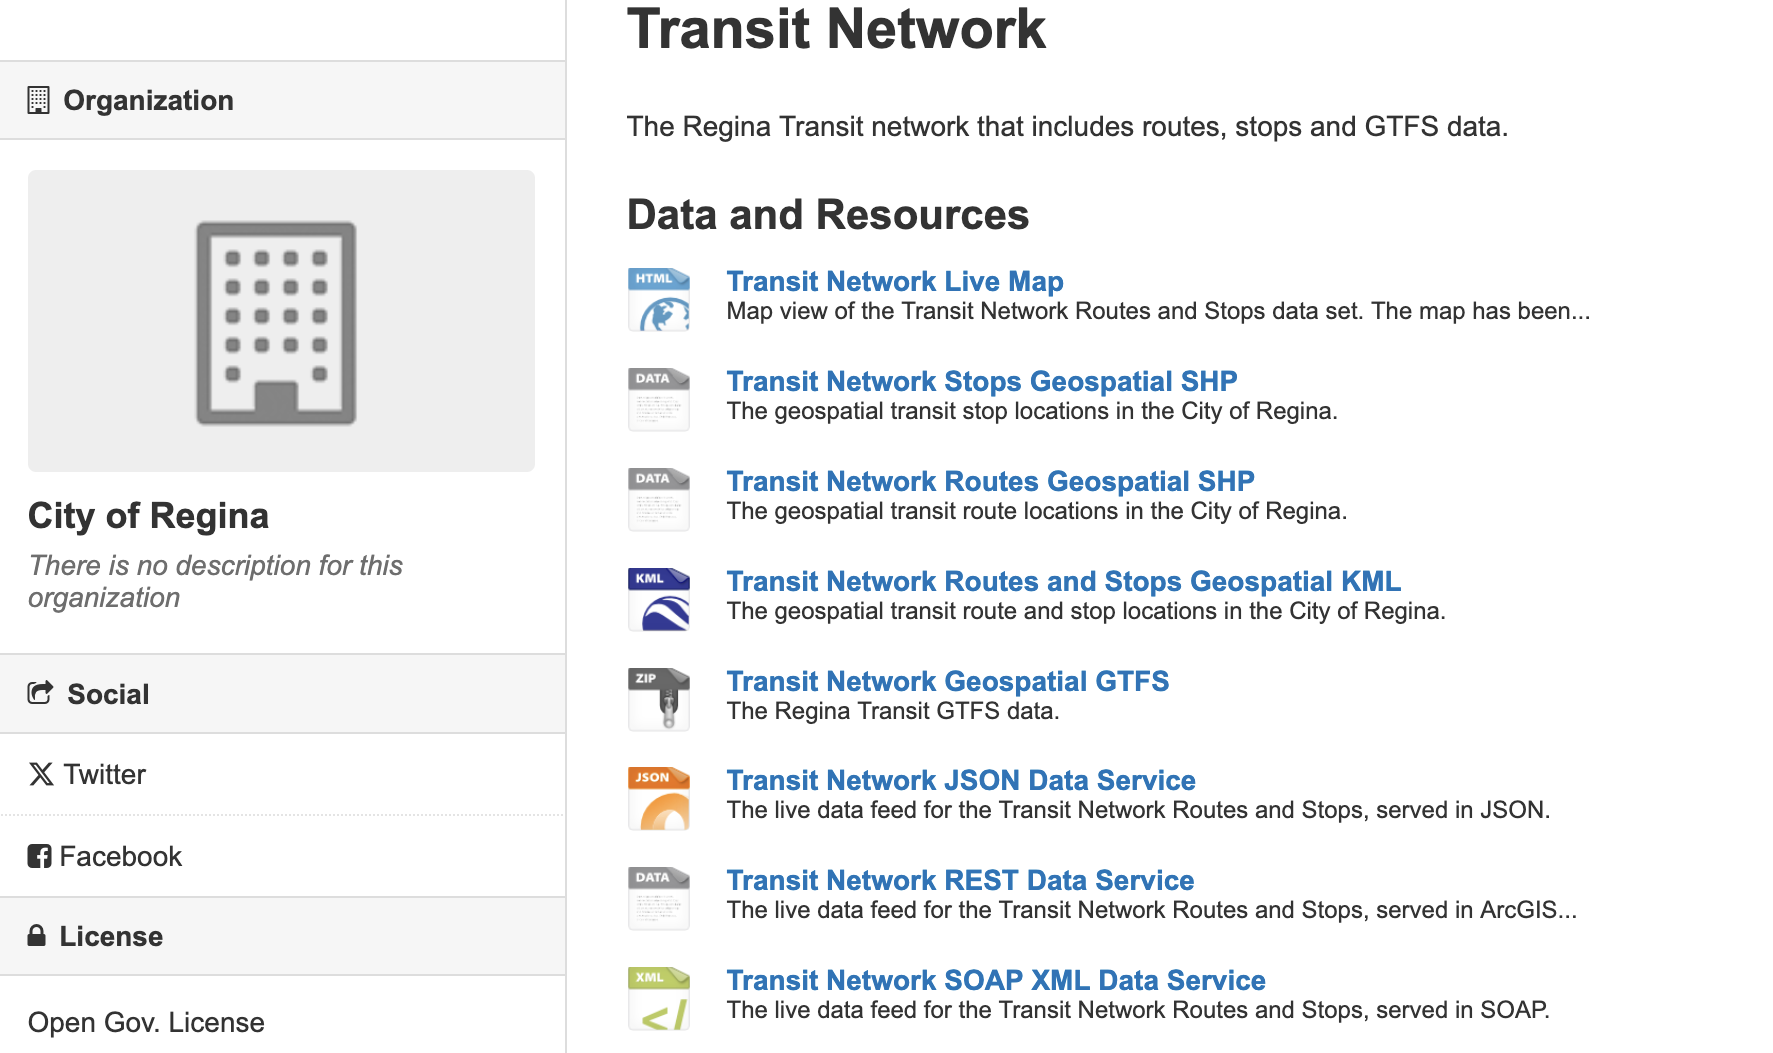

In [5]:
from IPython.display import Image
Image('open_regina_license.png')

# Tools
## VS Code Extensions:
- Python
- Python Environments
- Data Wrangler
- Jupyter

## Rationale
- large dataset
- flexibility, memory management
- macOS
- personal expertise

## Imported Python Libraries
```python
import numpy as np # scientific computing for large, multi-dimensional arrays
from matplotlib import pyplot as plt # creates static, animated, and interactive visualizations
import pandas as # pdcreates 2D, size-mutable, heterogeneous tables called data frames
import json # read and write json files
import plotly.graph_objects as go # interactive graphics like maps
from pyproj import Transformer # cartography and coordinate transformations
```

In [2]:
# Load stop data
try:
    with open('../raw_data/yqrStops.json', 'r') as f:
        stop_data = json.load(f)
except json.decoder.JSONDecodeError as e:
    print("Invalid JSON", e)

# Normalize nested JSON structure
df = pd.json_normalize(stop_data['features'], meta_prefix='attributes.')
df.columns = df.columns.str.replace('attributes.', '')
# Filtre specific columns for analysis
stop_columns = ['ONSTREET', 'ATSTREET', 'LON', 'LAT', 'STOP_ID', 'STOP_NAME']
df_stops = df[stop_columns]

print(f"**Loaded bus stops:**{len(df_stops)}")
df_stops.head(5)

**Loaded bus stops:**1000


,ONSTREET,ATSTREET,LON,LAT,STOP_ID,STOP_NAME
0,University Park Dr,Quance St (NB),-104.54913,50.44416,0742,University Park Dr @ Quance St (NB)
1,University Park Dr,Vic Square (NB),-104.54915,50.44592,0743,University Park Dr @ Vic Square (NB)
2,Fleet St,North Service Rd (NB),-104.549126,50.448609,0744,Fleet St @ North Service Rd (NB)
3,Fleet St,Fines Dr (NB),-104.549111,50.449614,0745,Fleet St @ Fines Dr (NB)
4,Cambridge Ave,Milford Cres (WB),-104.5513,50.45041,0746,Cambridge Ave @ Milford Cres (WB)


# Data Profiling: Quality Assessment - Stops
- **Data types** - Are coordinates stored correctly?
- **Missing values** - Which columns have gaps?
- **Duplicates** - Any duplicate stop IDs?
- **Outliers** - Any stops in unexpected locations?
- **Cardinalities** - How many unique stops?

## Stop Data Types

In [7]:
print(df_stops.dtypes)

ONSTREET     object
ATSTREET     object
LON          object
LAT          object
STOP_ID      object
STOP_NAME    object
dtype: object


## Missing Values

In [8]:
missing = df_stops.isnull().sum()
print(missing)

ONSTREET     0
ATSTREET     1
LON          0
LAT          0
STOP_ID      0
STOP_NAME    0
dtype: int64


## Duplicates

In [9]:
duplicates = df_stops.duplicated(subset=['STOP_ID']).sum()
print(f"Number of Duplicate Stops - checked by stop ID: {duplicates}")

Number of Duplicate Stops - checked by stop ID: 0


# Cleaning: Bus Stop Text Standardization & Type Conversions

## Problems identified
- Inconsistent text formatting (mixed case, whitespace)
- Coordinates stored as strings instead of numeric latitude and longitude
- Missing values in street names

In [10]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df_stops):
    # Remove leading and trailing whitespace in column: 'ONSTREET'
    df_stops['ONSTREET'] = df_stops['ONSTREET'].str.strip()
    # Convert text to uppercase in column: 'ONSTREET'
    df_stops['ONSTREET'] = df_stops['ONSTREET'].str.upper()
    # Remove leading and trailing whitespace in column: 'ATSTREET'
    df_stops['ATSTREET'] = df_stops['ATSTREET'].str.strip()
    # Convert text to uppercase in column: 'ATSTREET'
    df_stops['ATSTREET'] = df_stops['ATSTREET'].str.upper()
    # Remove leading and trailing whitespace in column: 'LON'
    df_stops['LON'] = df_stops['LON'].str.strip()
    # Remove leading and trailing whitespace in column: 'LAT'
    df_stops['LAT'] = df_stops['LAT'].str.strip()
    # Remove leading and trailing whitespace in column: 'stop_id'
    df_stops['STOP_ID'] = df_stops['STOP_ID'].str.strip()
    # Remove leading and trailing whitespace in column: 'STOP_NAME'
    df_stops['STOP_NAME'] = df_stops['STOP_NAME'].str.strip()
    # Convert text to uppercase in column: 'STOP_NAME'
    df_stops['STOP_NAME'] = df_stops['STOP_NAME'].str.upper()
    # Replace missing values with "DOROTHY ST (SB)" in column: 'ATSTREET'
    df_stops = df_stops.fillna({'ATSTREET':"DOROTHY ST (SB)"})
    # Replace all instances of "1060 DOROTHY ST (SB)" with "DOROTHY ST" in column: 'ONSTREET'
    df_stops['ONSTREET'] = df_stops['ONSTREET'].str.replace("1060 DOROTHY ST (SB)", "DOROTHY ST", case=False, regex=False)
    # Rename column 'ONSTREET' to 'on_street'
    df_stops = df_stops.rename(columns={'ONSTREET': 'on_street'})
    # Rename column 'ATSTREET' to 'at_street'
    df_stops = df_stops.rename(columns={'ATSTREET': 'at_street'})
    # Rename column 'LON' to 'stop_lon'
    df_stops = df_stops.rename(columns={'LON': 'stop_lon'})
    # Rename column 'LAT' to 'stop_lat'
    df_stops = df_stops.rename(columns={'LAT': 'stop_lat'})
    # Rename column 'stop_id' to 'stop_id'
    df_stops = df_stops.rename(columns={'STOP_ID': 'stop_id'})
    # Rename column 'STOP_NAME' to 'stop_name'
    df_stops = df_stops.rename(columns={'STOP_NAME': 'stop_name'})
    # Rename column 'GLOBALID' to 'global_id'
    df_stops = df_stops.rename(columns={'GLOBALID': 'global_id'})
    # Change 'stop_id' to 'int64'
    df_stops = df_stops.astype({'stop_id': 'int64'})
    return df_stops

clean_stops= clean_data(df_stops.copy())
clean_stops.head(5)

print(f"**Cleaned {len(clean_stops)} bus stops**")
clean_stops.head(5)

**Cleaned 1000 bus stops**


,on_street,at_street,stop_lon,stop_lat,stop_id,stop_name
0,UNIVERSITY PARK DR,QUANCE ST (NB),-104.54913,50.44416,742,UNIVERSITY PARK DR @ QUANCE ST (NB)
1,UNIVERSITY PARK DR,VIC SQUARE (NB),-104.54915,50.44592,743,UNIVERSITY PARK DR @ VIC SQUARE (NB)
2,FLEET ST,NORTH SERVICE RD (NB),-104.549126,50.448609,744,FLEET ST @ NORTH SERVICE RD (NB)
3,FLEET ST,FINES DR (NB),-104.549111,50.449614,745,FLEET ST @ FINES DR (NB)
4,CAMBRIDGE AVE,MILFORD CRES (WB),-104.5513,50.45041,746,CAMBRIDGE AVE @ MILFORD CRES (WB)


# Visual Check of Bus Stops

In [11]:
#Adapted from the Plotly documentation https://plotly.com/python/tile-scatter-maps/#multiple-markers
stop_fig = go.Figure(go.Scattermap(
    lat=clean_stops['stop_lat'],
    lon=clean_stops['stop_lon'],
    mode='markers',
    marker=go.scattermap.Marker(size=9),
    text=clean_stops['stop_name'],
))

stop_fig.update_layout(
    autosize=True,
    hovermode='closest',
    map=dict(
        bearing=0,
        center=dict(lat=50.447992743219615, lon=-104.61228441057489),
        pitch=0,
        zoom=10
    ),
)

stop_fig.show()

 # Loading Routes Data
 - SHAPE.LEN
 - ROUTE_NAME
 - ROUTE_NUM
 - ROUTE_COLOR

In [12]:
# Load routes
try:
    with open('../raw_data/yqrRoutes.json', 'r') as f:
        routes_data = json.load(f)
except json.decoder.JSONDecodeError as e:
    print("Invalid JSON", e)
df2 = pd.json_normalize(routes_data['features'], meta_prefix='attributes.')
df2.columns = df2.columns.str.replace('attributes.', '')
route_columns = ['ROUTE_ID','SHAPE.LEN', 'ROUTE_NAME','ROUTE_NUM', 'ROUTE_COLOR', 'geometry.paths']
df_routes = df2[route_columns]

In [13]:
df_routes.head(5)

,ROUTE_ID,SHAPE.LEN,ROUTE_NAME,ROUTE_NUM,ROUTE_COLOR,geometry.paths
0,10-44,184989.734238,RCMP - NORMANVIEW,10,FF0FF9,"[[[521564.20469999965, 5591834.3639], [521562...."
1,18-44,47401.585527,HARBOUR LANDING - UNIVERSITY,18,80FF00,"[[[526923.1776999999, 5585099.4342], [526923.0..."
2,3-44,180172.679776,UNIVERSITY - SHERWOOD ESTATES,3,A8A800,"[[[530186.9751000004, 5583983.2191], [530210.6..."
3,40-44,92096.531471,ALBERT S EXPRESS - ALBERT N EXPRESS,40,00CECE,"[[[525147.5691, 5594036.3595], [525147.4778000..."
4,60-44,57978.961540,ARCOLA E EXP - ARCOLA DWTN EXP,60,808000,"[[[533800.2019999996, 5585861.5229], [533799.1..."


# Data Profile: Quality Assessment - Routes
- **Data types** - Are coordinates stored correctly?
- **Missing values** - Which columns have gaps?
- **Duplicates** - Any duplicate route IDs?
- **Outliers** - Any routes in unexpected locations?
- **Cardinalities** - How many unique routes?


## Route Data Types

In [14]:
print(df_routes.dtypes[df_routes.columns[:6]])

ROUTE_ID           object
SHAPE.LEN         float64
ROUTE_NAME         object
ROUTE_NUM          object
ROUTE_COLOR        object
geometry.paths     object
dtype: object


## No Missing or Duplicate Routes

In [15]:
print(df_routes.isnull().sum())

ROUTE_ID          0
SHAPE.LEN         0
ROUTE_NAME        0
ROUTE_NUM         0
ROUTE_COLOR       0
geometry.paths    0
dtype: int64


In [16]:
print(df_routes.duplicated(subset=['ROUTE_ID']).sum())

0


 # Cleaning: Bus Route Text Standardization & Type Conversions
 - inconsistent text formatting
 - missing colours
 - hex values missing
 - standardize column names


 ```python
 # add a hashtag in front of the route colour hex values
 df_routes['ROUTE_COLOR'] = '#' + (df_routes['ROUTE_COLOR'].str.strip()).astype(str)
 ```

# Bus Route Cleaning Summary
- inconsistent text formatting
- missing colours
- hex values missing
- standardize column names

In [17]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df_routes):
    # Remove leading and trailing whitespace in columns: 'ROUTE_NAME', 'ROUTE_NUM' and 4 other columns
    df_routes['ROUTE_NAME'] = df_routes['ROUTE_NAME'].str.strip()
    df_routes['ROUTE_NUM'] = df_routes['ROUTE_NUM'].str.strip()
    df_routes['ROUTE_ID'] = df_routes['ROUTE_ID'].str.strip()
    # add a hashtag in front of the route colour hex values 
    df_routes['ROUTE_COLOR'] = '#' + (df_routes['ROUTE_COLOR'].str.strip()).astype(str)
    # Convert text to uppercase in column: 'ROUTE_NAME'
    df_routes['ROUTE_NAME'] = df_routes['ROUTE_NAME'].str.upper()
    #  Rename column 'SHAPE.LEN' to 'shape_length'
    df_routes = df_routes.rename(columns={'SHAPE.LEN': 'shape_length'})
    # Rename column 'ROUTE_NAME' to 'route_name'
    df_routes = df_routes.rename(columns={'ROUTE_NAME': 'route_name'})
    # Rename column 'ROUTE_NUM' to 'route_num'
    df_routes = df_routes.rename(columns={'ROUTE_NUM': 'route_num'})
    # Rename column 'ROUTE_ID' to 'route_id'
    df_routes = df_routes.rename(columns={'ROUTE_ID': 'route_id'})
    # Rename column 'ROUTE_COLOR' to 'route_color'
    df_routes = df_routes.rename(columns={'ROUTE_COLOR': 'route_color'})
    # Rename column 'geometry.paths' to 'geometry_paths'
    df_routes = df_routes.rename(columns={'geometry.paths': 'geometry_paths'})
    return df_routes

clean_routes = clean_data(df_routes.copy())
clean_routes.head(5)

print(f"**Cleaned routes:** {len(clean_routes)}")
clean_routes[['route_num', 'route_name', 'route_color']].head(5)

**Cleaned routes:** 22


,route_num,route_name,route_color
0,10,RCMP - NORMANVIEW,#FF0FF9
1,18,HARBOUR LANDING - UNIVERSITY,#80FF00
2,3,UNIVERSITY - SHERWOOD ESTATES,#A8A800
3,40,ALBERT S EXPRESS - ALBERT N EXPRESS,#00CECE
4,60,ARCOLA E EXP - ARCOLA DWTN EXP,#808000


# Transformation 1: Transform Route Coordinates

## Prepare Routes for Visualization
```python
# Create transformer to convert from UTM to lat/lon
transformer = Transformer.from_crs("EPSG:26913", "EPSG:4326", always_xy=True)
```

# Visual Check of a Bus Route

In [18]:
# Create transformer to convert from UTM to lat/lon
transformer = Transformer.from_crs("EPSG:26913", "EPSG:4326", always_xy=True)

route_idx = 0

route_name = clean_routes['route_name'].iloc[route_idx]
route_geometry = clean_routes['geometry_paths'].iloc[route_idx]
route_colour = clean_routes['route_color'].iloc[route_idx]
route_text_colour = '#fffff'

# Combine all paths into single lists
all_lons = []
all_lats = []

for path in route_geometry:
    for coordinate in path:
        lon, lat = transformer.transform(coordinate[0], coordinate[1])
        all_lons.append(lon)
        all_lats.append(lat)
    
    # Add None to separate path segments (prevents connecting them)
    all_lons.append(None)
    all_lats.append(None)

# Add as ONE trace
stop_fig.add_trace(go.Scattermap(
    lon=all_lons,
    lat=all_lats,
    mode='lines',
    line=dict(width=3, color=route_colour),
    name=route_name,
    hovertemplate=f'<b>{route_name}</b><extra></extra>'
))

stop_fig.show()

# Loading GTFS Schedule Data

In [19]:
# Load GTFS data
stops_gtfs = pd.read_csv('../raw_data/gtfs_data/stops.txt')
routes_gtfs = pd.read_csv('../raw_data/gtfs_data/routes.txt')
trips_gtfs = pd.read_csv('../raw_data/gtfs_data/trips.txt')
times_gtfs = pd.read_csv('../raw_data/gtfs_data/stop_times.txt')

In [20]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(stops_gtfs):
    # Convert text to uppercase in column: 'stop_name'
    stops_gtfs['stop_name'] = stops_gtfs['stop_name'].str.upper()
    # Remove leading and trailing whitespace in column: 'stop_name'
    stops_gtfs['stop_name'] = stops_gtfs['stop_name'].str.strip()
     # Drop column: 'parent_station'
    stops_gtfs = stops_gtfs.drop(columns=['parent_station'])
    # Drop column: 'location_type'
    stops_gtfs = stops_gtfs.drop(columns=['location_type'])
    # Drop column: 'stop_desc'
    stops_gtfs = stops_gtfs.drop(columns=['stop_desc'])
    # Drop column: 'stop_code'
    stops_gtfs = stops_gtfs.drop(columns=['stop_code'])
    # Drop column: 'zone_id'
    stops_gtfs = stops_gtfs.drop(columns=['zone_id'])
    # Drop column: 'stop_url'
    stops_gtfs = stops_gtfs.drop(columns=['stop_url'])
    return stops_gtfs
stops_gtfs_clean = clean_data(stops_gtfs.copy())

In [21]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(routes_gtfs):
    # Convert text to uppercase in column: 'route_long_name'
    routes_gtfs['route_long_name'] = routes_gtfs['route_long_name'].str.upper()
    # Remove leading and trailing whitespace in column: 'route_long_name'
    routes_gtfs['route_long_name'] = routes_gtfs['route_long_name'].str.strip()
    # Drop column: 'route_url'
    routes_gtfs = routes_gtfs.drop(columns=['route_url'])
    # Drop column: 'route_desc'
    routes_gtfs = routes_gtfs.drop(columns=['route_desc'])
    # Drop column: 'route_text_color'
    routes_gtfs = routes_gtfs.drop(columns=['route_text_color'])
    return routes_gtfs
routes_gtfs_clean = clean_data(routes_gtfs.copy())
routes_gtfs

,route_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,1-44,1,DIEPPE/WESTERRA - BROAD NORTH,NaN,3,NaN,1AA68A,NaN
1,1-45,1,DIEPPE/WESTERRA - BROAD NORTH,NaN,3,NaN,1AA68A,NaN
2,2-44,2,ARGYLE PARK - WOOD MEADOWS,NaN,3,NaN,FF8000,NaN
3,2-45,2,ARGYLE PARK - WOOD MEADOWS,NaN,3,NaN,FF8000,NaN
4,3-44,3,UNIVERSITY - SHERWOOD ESTATES,NaN,3,NaN,A8A800,NaN
5,3-45,3,UNIVERSITY - SHERWOOD ESTATES,NaN,3,NaN,A8A800,NaN
6,4-44,4,HILLSDALE - WALSH ACRES,NaN,3,NaN,EAEA00,NaN
7,4-45,4,HILLSDALE - WALSH ACRES,NaN,3,NaN,EAEA00,NaN
8,5-44,5,UPLANDS - DOWNTOWN,NaN,3,NaN,0000A0,FFFFFF
9,5-45,5,UPLANDS - DOWNTOWN,NaN,3,NaN,0000A0,FFFFFF


In [22]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(times_gtfs):
    # Convert text to uppercase in column: 'trip_id'
    times_gtfs['trip_id'] = times_gtfs['trip_id'].str.upper()
    # Replace '24' in hour position with '00'
    times_gtfs['arrival_time'] = times_gtfs['arrival_time'].str.replace(r'^24', '00', regex=True)
    times_gtfs['departure_time'] = times_gtfs['departure_time'].str.replace(r'^24', '00', regex=True)
    # Remove leading and trailing whitespace in columns: 'trip_id', 'arrival_time', 'departure_time'
    times_gtfs['trip_id'] = times_gtfs['trip_id'].str.strip()
    times_gtfs['arrival_time'] = times_gtfs['arrival_time'].str.strip()
    times_gtfs['departure_time'] = times_gtfs['departure_time'].str.strip()
    # Drop column: 'pickup_type'
    times_gtfs = times_gtfs.drop(columns=['pickup_type'])
    # Drop column: 'stop_sequence'
    times_gtfs = times_gtfs.drop(columns=['stop_sequence'])
    # Drop column: 'drop_off_type'
    times_gtfs = times_gtfs.drop(columns=['drop_off_type'])
    return times_gtfs
times_gtfs_clean = clean_data(times_gtfs.copy())

In [23]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(trips_gtfs):
    # Remove leading and trailing whitespace in columns: 'route_id', 'service_id' and 2 other columns
    trips_gtfs['route_id'] = trips_gtfs['route_id'].str.strip()
    trips_gtfs['service_id'] = trips_gtfs['service_id'].str.strip()
    trips_gtfs['trip_id'] = trips_gtfs['trip_id'].str.strip()
    trips_gtfs['trip_headsign'] = trips_gtfs['trip_headsign'].str.strip()
    # Convert text to uppercase in columns: 'service_id', 'trip_id', 'trip_headsign'
    trips_gtfs['service_id'] = trips_gtfs['service_id'].str.upper()
    trips_gtfs['trip_id'] = trips_gtfs['trip_id'].str.upper()
    trips_gtfs['trip_headsign'] = trips_gtfs['trip_headsign'].str.upper()
    return trips_gtfs

trips_gtfs_clean = clean_data(trips_gtfs.copy())
trips_gtfs_clean.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,18-44,202502-MVS-WEEKDAY-01,218095-202502-MVS-WEEKDAY-01,UNIVERSITY,0,12208,180008
1,18-44,202502-MVS-WEEKDAY-01,218096-202502-MVS-WEEKDAY-01,UNIVERSITY,0,12209,180008
2,18-44,202502-MVS-WEEKDAY-01,218097-202502-MVS-WEEKDAY-01,UNIVERSITY,0,12208,180008
3,18-44,202502-MVS-WEEKDAY-01,218098-202502-MVS-WEEKDAY-01,UNIVERSITY,0,12209,180008
4,18-44,202502-MVS-WEEKDAY-01,218099-202502-MVS-WEEKDAY-01,UNIVERSITY,0,12208,180008


# GTFS Data Loaded:

In [24]:
print(f"- {len(stops_gtfs_clean)} stops")
print(f"- {len(routes_gtfs_clean)} routes")
print(f"- {len(times_gtfs_clean)} stop times")
print(f"- {len(trips_gtfs_clean)} trips")

- 1400 stops
- 44 routes
- 285722 stop times
- 5078 trips


# Transformation 2: Parsing Date/Time Data
- Problem: Time data stored as strings (HH:MM:SS)
- Solution: Parse to datetime and derive time-based features

In [25]:
times_gtfs_clean.head(5)

,trip_id,arrival_time,departure_time,stop_id,shape_dist_traveled,timepoint
0,218095-202502-MVS-WEEKDAY-01,06:10:00,06:10:00,1566,0.000,1
1,218095-202502-MVS-WEEKDAY-01,06:11:00,06:11:00,1403,0.263,0
2,218095-202502-MVS-WEEKDAY-01,06:12:00,06:12:00,1418,0.485,0
3,218095-202502-MVS-WEEKDAY-01,06:13:00,06:13:00,1411,0.717,0
4,218095-202502-MVS-WEEKDAY-01,06:14:00,06:14:00,1412,0.904,0


In [26]:
# Parse time columns
times_gtfs_clean['arrival_datetime'] = pd.to_datetime(
    times_gtfs_clean['arrival_time'], 
    format='%H:%M:%S',
    errors='coerce'
)

times_gtfs_clean['departure_datetime'] = pd.to_datetime(
    times_gtfs_clean['departure_time'], 
    format='%H:%M:%S',
    errors='coerce'
)

# Derive hour of day
times_gtfs_clean['arrival_hour'] = times_gtfs_clean['arrival_datetime'].dt.hour
times_gtfs_clean['arrival_minute'] = times_gtfs_clean['arrival_datetime'].dt.minute
times_gtfs_clean['departure_hour'] = times_gtfs_clean['departure_datetime'].dt.hour
times_gtfs_clean['departure_minute'] = times_gtfs_clean['departure_datetime'].dt.minute

print("Parsed time data and derived hour/minute features")
times_gtfs_clean[['arrival_time', 'arrival_datetime', 'arrival_hour', 'arrival_minute', 'departure_datetime', 'departure_time', 'departure_hour', 'departure_minute']].head(5)

Parsed time data and derived hour/minute features


,arrival_time,arrival_datetime,arrival_hour,arrival_minute,departure_datetime,departure_time,departure_hour,departure_minute
0,06:10:00,1900-01-01 06:10:00,6,10,1900-01-01 06:10:00,06:10:00,6,10
1,06:11:00,1900-01-01 06:11:00,6,11,1900-01-01 06:11:00,06:11:00,6,11
2,06:12:00,1900-01-01 06:12:00,6,12,1900-01-01 06:12:00,06:12:00,6,12
3,06:13:00,1900-01-01 06:13:00,6,13,1900-01-01 06:13:00,06:13:00,6,13
4,06:14:00,1900-01-01 06:14:00,6,14,1900-01-01 06:14:00,06:14:00,6,14


# Transformation 3: Merge/Join Operations
- 1400 stops
- Open Regina ASP.NET limit of 1000
- GTFS data contains some fields
- Imputation for the remaining

In [27]:
# make sure the join keys have the same data type
clean_stops['stop_id'] = clean_stops['stop_id'].astype('int64')
stops_gtfs_clean['stop_id'] = stops_gtfs_clean['stop_id'].astype('int64')

In [28]:
# Find stops in GTFS but not in geographic JSON data
missing_stops = stops_gtfs_clean[
    ~stops_gtfs_clean['stop_id'].isin(clean_stops['stop_id'])
]

# Merge datasets
merged_stops = pd.concat([clean_stops, missing_stops], ignore_index=True, sort=False)

# Impute missing street names from stop_name
for index, stop in merged_stops.iterrows():
    if pd.isna(stop['on_street']):
        merged_stops.at[index, 'on_street'] = stop['stop_name'].split(' @')[0]
    if pd.isna(stop['at_street']):
        merged_stops.at[index, 'at_street'] = stop['stop_name'].split('@ ')[-1]
print("""## Merged Stops Data""")
merged_stops.head(5)

## Merged Stops Data


,on_street,at_street,stop_lon,stop_lat,stop_id,stop_name
0,UNIVERSITY PARK DR,QUANCE ST (NB),-104.54913,50.44416,742,UNIVERSITY PARK DR @ QUANCE ST (NB)
1,UNIVERSITY PARK DR,VIC SQUARE (NB),-104.54915,50.44592,743,UNIVERSITY PARK DR @ VIC SQUARE (NB)
2,FLEET ST,NORTH SERVICE RD (NB),-104.549126,50.448609,744,FLEET ST @ NORTH SERVICE RD (NB)
3,FLEET ST,FINES DR (NB),-104.549111,50.449614,745,FLEET ST @ FINES DR (NB)
4,CAMBRIDGE AVE,MILFORD CRES (WB),-104.5513,50.45041,746,CAMBRIDGE AVE @ MILFORD CRES (WB)


# Find the Missing Stops

In [29]:
missing_stops = stops_gtfs_clean[~stops_gtfs_clean['stop_id'].isin(clean_stops['stop_id'])]

In [30]:
# Find missing stops
missing_stops = stops_gtfs_clean[~stops_gtfs_clean['stop_id'].isin(clean_stops['stop_id'])]

print(f"**Found stops in GTFS data:**{len(missing_stops)}")

# Merge
merged_stops = pd.concat([clean_stops, missing_stops], ignore_index=True, sort=False)
print(len(missing_stops), "new stops added")

**Found stops in GTFS data:**400
400 new stops added


In [31]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(merged_stops):
    for index, stop in merged_stops.iterrows():
        if pd.isna(stop['on_street']):
            merged_stops.at[index, 'on_street'] = (
                str(merged_stops.at[index, 'stop_name']).split(' @')[0]
            )
        if pd.isna(stop['at_street']):
            merged_stops.at[index, 'at_street'] = (
                str(merged_stops.at[index, 'stop_name']).split('@ ')[-1]
            )
    return merged_stops

merged_stops_clean = clean_data(merged_stops.copy())

In [32]:
print(f"Total stops after merge: {len(merged_stops_clean)} ({len(missing_stops)} added)")
merged_stops_clean.head(5)

Total stops after merge: 1400 (400 added)


,on_street,at_street,stop_lon,stop_lat,stop_id,stop_name
0,UNIVERSITY PARK DR,QUANCE ST (NB),-104.54913,50.44416,742,UNIVERSITY PARK DR @ QUANCE ST (NB)
1,UNIVERSITY PARK DR,VIC SQUARE (NB),-104.54915,50.44592,743,UNIVERSITY PARK DR @ VIC SQUARE (NB)
2,FLEET ST,NORTH SERVICE RD (NB),-104.549126,50.448609,744,FLEET ST @ NORTH SERVICE RD (NB)
3,FLEET ST,FINES DR (NB),-104.549111,50.449614,745,FLEET ST @ FINES DR (NB)
4,CAMBRIDGE AVE,MILFORD CRES (WB),-104.5513,50.45041,746,CAMBRIDGE AVE @ MILFORD CRES (WB)


# Transformation 4: Feature Derivation - Geographic Regions
**Divide the city into four quadrants** based on approximate city centre coordinates (Albert St & Victoria Ave Intersection)

In [33]:
# Derive Bus Stops by Region
city_centre_lon = -104.618
city_centre_lat = 50.447
merged_stops_clean['region'] = ''

# Assign quadrants (NE, NW, SE, SW)
for stop in range(len(merged_stops_clean)):
    if float(merged_stops_clean['stop_lat'].iloc[stop]) > city_centre_lat:
        if float(merged_stops_clean['stop_lon'].iloc[stop]) > city_centre_lon:
            merged_stops_clean.at[stop, 'region'] = "NE"
        else:
            merged_stops_clean.at[stop, 'region'] = "NW"
    else:
        if float(merged_stops_clean['stop_lon'].iloc[stop]) > city_centre_lon:
            merged_stops_clean.at[stop, 'region'] = "SE"
        else:
            merged_stops_clean.at[stop, 'region'] = "SW"

# Derived regional classifications for all stops

In [34]:
# Show distribution of stops per region
region_counts = merged_stops_clean['region'].value_counts()

## Stop distribution by region:

In [35]:
print(f"""
- NW: {region_counts.get('NW', 0)} stops
- NE: {region_counts.get('NE', 0)} stops
- SW: {region_counts.get('SW', 0)} stops
- SE: {region_counts.get('SE', 0)} stops
""")


- NW: 491 stops
- NE: 322 stops
- SW: 243 stops
- SE: 344 stops



# Exploratory Data Analysis Check: Bus Stops by Region

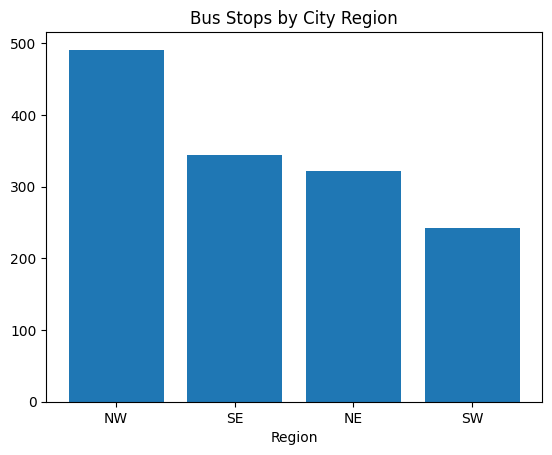

In [36]:
region_counts = merged_stops_clean['region'].value_counts()
plt.bar(region_counts.index, region_counts.values)
plt.title('Bus Stops by City Region')
plt.xlabel('Region')
plt.show()

# Transformation 5: Feature Derivation - Distance Calculations
- In ArcGIS/GIS systems, shape.len (shape length) represents the total length of the geometry in metres

## Bus Route Distance
```python
# convert shape_length into km
clean_routes['route_distance_km'] = clean_routes['shape_length'] / 1000
```

In [37]:
# convert shape_length into km
clean_routes['route_distance_km'] = clean_routes['shape_length'] / 1000

In [38]:
clean_routes[['route_num', 'route_distance_km']].head(5)

,route_num,route_distance_km
0,10,184.989734
1,18,47.401586
2,3,180.172680
3,40,92.096531
4,60,57.978962


# Exploratory Data Analysis Check: Top 10 Longest Bus Routes

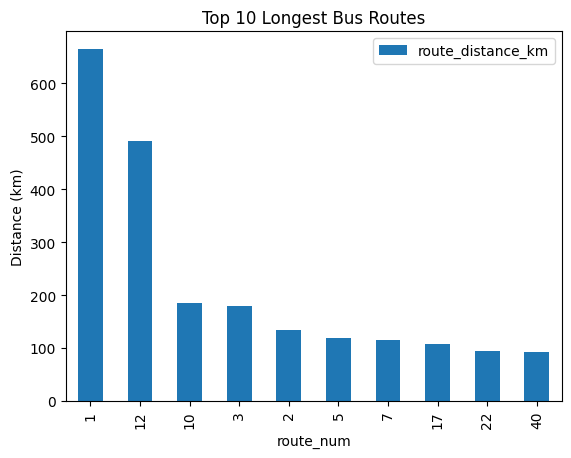

In [39]:
clean_routes.sort_values('route_distance_km', ascending=False).head(10).plot(
    x='route_num', y='route_distance_km', kind='bar'
)
plt.title('Top 10 Longest Bus Routes')
plt.ylabel('Distance (km)')
plt.show()

## Euclidean Distance from City Centre

In [40]:
# Approximate conversion: ~111 km per degree latitude, ~85 km per degree longitude at this latitude
# Euclidean distance
merged_stops_clean['distance_from_centre_km'] = np.sqrt(
    ((merged_stops_clean['stop_lat'].astype(float) - city_centre_lat) * 111)**2 + 
    ((merged_stops_clean['stop_lon'].astype(float) - city_centre_lon) * 85)**2)

In [41]:
print("\nDistance statistics (km):")
print(merged_stops_clean['distance_from_centre_km'].describe())


Distance statistics (km):
count    1400.000000
mean        4.218992
std         2.063648
min         0.032413
25%         2.632338
50%         4.109679
75%         5.649194
max        11.352437
Name: distance_from_centre_km, dtype: float64


# EDA Check: Distribution of Stop Distances from City Centre

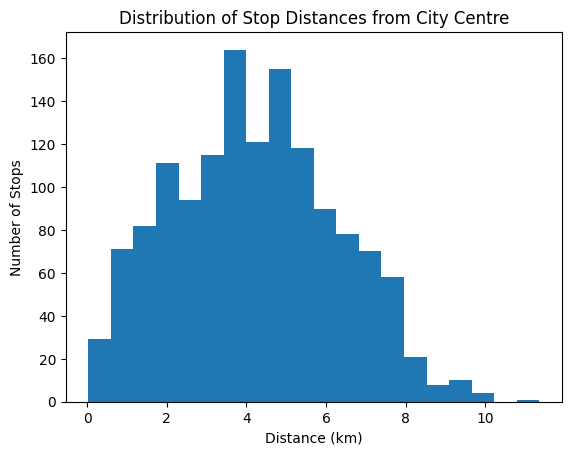

In [42]:
plt.hist(merged_stops_clean['distance_from_centre_km'], bins=20)
plt.title('Distribution of Stop Distances from City Centre')
plt.xlabel('Distance (km)')
plt.ylabel('Number of Stops')
plt.show()

# Transformation 5: Aggregation
## Aggregate stops by region to understand service distribution:

In [43]:
summary = merged_stops_clean.groupby('region').agg({
'stop_id': 'count',
'distance_from_centre_km': ['mean', 'min', 'max']
})
print(summary)

       stop_id distance_from_centre_km                     
         count                    mean       min        max
region                                                     
NE         322                4.138518  0.132092   7.663540
NW         491                4.497206  0.156078   8.526096
SE         344                4.670094  0.286489  10.115952
SW         243                3.124878  0.032413  11.352437


# Transformation 6: Reshape (Pivot)

In [44]:
# Ensure join keys have the same dtype to avoid merge mismatches
# Cast stop_id/trip_id/route_id to string on both sides of joins
# Reshape: Routes by Region
times_gtfs_clean['trip_id'] = times_gtfs_clean['trip_id'].astype(str)
times_gtfs_clean['stop_id'] = times_gtfs_clean['stop_id'].astype(str)
merged_stops_clean['stop_id'] = merged_stops_clean['stop_id'].astype(str)

route_stops = (
    times_gtfs_clean
    .merge(trips_gtfs_clean[['trip_id', 'route_id']], on='trip_id')
    .merge(merged_stops_clean[['stop_id', 'region']], left_on='stop_id', right_on='stop_id')
    .groupby(['route_id', 'region'])
    .size()
    .reset_index(name='stop_count')
)

# Pivot wider
route_region_pivot = route_stops.pivot(
    index='route_id', 
    columns='region', 
    values='stop_count'
).fillna(0)

## Routes by Region (Pivoted):

In [45]:
route_region_pivot.head(5)

region,NE,NW,SE,SW
route_id,,,,
1-44,5383.0,5662.0,0.0,60.0
1-45,5335.0,5602.0,0.0,60.0
10-44,1609.0,5524.0,0.0,1523.0
10-45,1521.0,5236.0,0.0,1439.0
12-44,561.0,5110.0,6243.0,0.0


# Cardinality

In [46]:
print(f"Unique stops: {merged_stops_clean['stop_id'].nunique()}")
print(f"Features: {len(merged_stops_clean.columns)} columns")

Unique stops: 1400
Features: 8 columns


# Outlier Analysis

In [47]:
outliers = merged_stops_clean[merged_stops_clean['distance_from_centre_km'] > 15]
print(f"Found {len(outliers)} outlier stops (>15km from city centre)")
if len(outliers) > 0:
    print(outliers[['stop_name', 'distance_from_centre_km']].head(5))

Found 0 outlier stops (>15km from city centre)


# Before (Raw DAta)

In [48]:
print(f"Stop rows: {len(df_stops)}")
print(f"Route rows: {len(df_routes)}")
print(f"Missing ATSTREET: {df_stops['ATSTREET'].isnull().sum()}")
print(f"Coordinate type: {df_stops['LAT'].dtype} (string)")
print(f"Stop ID type: {df_stops['STOP_ID'].dtype} (string)")
print(f"Features: 8 columns")

Stop rows: 1000
Route rows: 22
Missing ATSTREET: 1
Coordinate type: object (string)
Stop ID type: object (string)
Features: 8 columns


# AFTER (Cleaned & Transformed)

In [49]:
print(f"Stop rows: {len(merged_stops_clean)} (+{len(missing_stops)} from GTFS)")
print(f"Route rows: {len(clean_routes)}")
print(f"Missing ATSTREET: {merged_stops_clean['at_street'].isnull().sum()}")
print(f"Coordinate type: {merged_stops_clean['stop_lat'].dtype} (numeric-ready)")
print(f"Stop ID type: {merged_stops_clean['stop_id'].dtype} (int64 for joins)")
print(f"Features: {len(merged_stops_clean.columns)} columns")
print(f"New derived features: region, route_distance_km, distance_from_centre_km")
print(f"Parsed time features: arrival_hour, arrival_minute, departure_hour, departure_minute")

Stop rows: 1400 (+400 from GTFS)
Route rows: 22
Missing ATSTREET: 0
Coordinate type: object (numeric-ready)
Stop ID type: object (int64 for joins)
Features: 8 columns
New derived features: region, route_distance_km, distance_from_centre_km
Parsed time features: arrival_hour, arrival_minute, departure_hour, departure_minute


# Summary of Transformations

### Completed Transformations (8 operations across 5 categories):

1. Converted Coordinate to Latitude and Longitude
2. Parse Date/Time
3. Merge Bus Stops
4. Feature Derivations - Geographic Regions, route distance, stop distance from city centre
5. Aggregate Stops By Region
6. Pivot Table

# Reproducibility

### How to reproduce this analysis:
**1. Install dependencies:**
```bash
pip install pandas plotly pyproj numpy jupyter
```
**2. Directory structure:**
```
project/
├── transit_data.ipynb
├── raw_data/
│   ├── yqrStops.json
│   ├── yqrRoutes.json
│   └── gtfs_data/
│       ├── stops.txt
│       ├── routes.txt
│       ├── trips.txt
│       └── stop_times.txt
└── README.md
```
**3. Run notebook:**
- Command line: jupyter notebook transit_data.ipynb
- In VS Code: Execute all cells sequentially

## Tool Versions
- Python: 3.14.0
- pandas: 2.3.3
- numpy: 2.3.5
- plotly: 6.5.0
- pyproj: 3.7.2
- matplotlib: 3.9.3